<a href="https://colab.research.google.com/github/FRfans/time-series-human-activities/blob/main/Kode_Backropagation_Kelompok_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

##Hyperparameter, Data path, dan Fitur Target

In [ ]:
# Configuration settings
DATA_PATH = 'time_series_data_human_activities.csv'
ACTIVITIES = ['Walking', 'Jogging', 'Sitting']
FEATURES = ['x-axis', 'y-axis', 'z-axis']
HIDDEN_SIZES = [128, 64]
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 32
RANDOM_SEED = 42

##Fungsi Preprocessing data

In [ ]:
def load_data():
    """Load and filter the dataset."""
    print("Loading data from:", DATA_PATH)
    data = pd.read_csv(DATA_PATH)
    filtered_data = data[data['activity'].isin(ACTIVITIES)]
    print(f"Loaded {len(filtered_data)} records with activities: {', '.join(ACTIVITIES)}")
    print("Sample of loaded data:\n", filtered_data.head())
    activity_counts = filtered_data['activity'].value_counts()
    print("\nActivity counts:")
    print(activity_counts)
    return filtered_data

def balance_data(data):
    """Balance classes by sampling each activity to the same number of samples."""
    min_samples = data['activity'].value_counts().min()
    balanced_data = pd.concat([
        data[data['activity'] == activity].sample(min_samples, random_state=RANDOM_SEED)
        for activity in ACTIVITIES
    ])
    print(f"Balanced data to {min_samples} samples per activity.")
    # Display count of balanced data per activity
    print("\nBalanced data counts per activity:")
    print(balanced_data['activity'].value_counts())

    return balanced_data.reset_index(drop=True)


def aggregate_records(df, n=20):
    """Aggregate every n records with the same activity by calculating the mean for each group."""
    df = df.reset_index(drop=True)
    result = []

    for activity in df['activity'].unique():
        # Filter data for each activity
        activity_df = df[df['activity'] == activity].copy()

        # Group every n records and calculate the mean
        aggregated = pd.concat([
            activity_df.iloc[i:i + n].mean(numeric_only=True).to_frame().T.assign(activity=activity)
            for i in range(0, len(activity_df), n)
        ], ignore_index=True)

        result.append(aggregated)

    # Combine final result for all activities
    final_result = pd.concat(result, ignore_index=True)

    # Display count of aggregated data per activity
    print("\nAggregated data counts per activity:")
    print(final_result['activity'].value_counts())
    print(f"Final shape: {final_result.shape}")

    return final_result

def prepare_data(normalize=True, aggregation_size=20):
    """Prepare data for training."""
    # Load and preprocess data
    data = load_data()
    balanced_data = balance_data(data)
    aggregated_data = aggregate_records(balanced_data, n=aggregation_size)

    # Prepare features
    X = aggregated_data[FEATURES].values

    # Normalize if requested
    if normalize:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        print("\nFeatures normalized. Mean:", X.mean(axis=0))
        print("Features std:", X.std(axis=0))
        print("Sample of normalized features:\n", X[:5])

    # Encode labels
    y = LabelEncoder().fit_transform(aggregated_data['activity'])
    print(f"Encoded labels into {len(set(y))} classes.")
    print("Sample of encoded labels:\n", y[:5])

    return X, y

##Inisialisasi layer, bias,dan weight

In [ ]:
def initialize_network(input_size, hidden_sizes, num_classes):
    """Initialize network layers and biases using He initialization."""
    all_sizes = [input_size] + hidden_sizes + [num_classes]
    layers = [

        np.random.randn(all_sizes[i], all_sizes[i+1]) * np.sqrt(2./all_sizes[i])
        for i in range(len(all_sizes) - 1)
    ]
    biases = [np.zeros((1, size)) for size in all_sizes[1:]]
    return layers, biases

## Fungsi aktivasi beserta turunannya dan Fungsi loss

In [ ]:
def relu(Z):
    """ReLU activation function."""
    return np.maximum(0, Z)

def relu_derivative(Z):
    """Derivative of ReLU for backpropagation."""
    return Z > 0

def softmax(Z):
    """Softmax activation for output layer to get class probabilities."""
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stability fix by subtracting max(Z)
    return exp_Z / exp_Z.sum(axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels):
    """Calculate cross-entropy loss for given predictions and true labels."""
    m = labels.shape[0]
    log_likelihood = -np.log(predictions[range(m), labels] + 1e-8)
    loss = np.sum(log_likelihood) / m
    return loss

## Fungsi feedforward

In [ ]:
def forward(X, layers, biases):
    """Forward pass through the network."""
    activations = [X]

    # Hidden layers with ReLU activation
    for i in range(len(layers) - 1):
        Z = np.dot(activations[-1], layers[i]) + biases[i]
        A = relu(Z)
        activations.append(A)

    # Output layer with Softmax activation
    Z_final = np.dot(activations[-1], layers[-1]) + biases[-1]
    A_final = softmax(Z_final)
    activations.append(A_final)

    return activations

##Fungsi Backpropagation

In [ ]:
def backward(X, Y, activations, layers, biases, learning_rate):
    """Backward propagation and gradient updates for MLP."""
    m = X.shape[0]
    num_layers = len(layers)
    dW = [np.zeros_like(layer) for layer in layers]
    db = [np.zeros_like(bias) for bias in biases]

    # Gradient of cross-entropy loss with softmax
    dZ = activations[-1].copy()
    dZ[range(m), Y] -= 1  # Adjust to compute the gradient w.r.t logits
    dZ /= m

    # Backpropagation for each layer
    for l in reversed(range(num_layers)):
        # Compute weight and bias gradients
        dW[l] = np.dot(activations[l].T, dZ)
        db[l] = np.sum(dZ, axis=0, keepdims=True)

        # Compute gradient for the previous layer (if not input layer)
        if l > 0:
            dA = np.dot(dZ, layers[l].T)
            dZ = dA * relu_derivative(np.dot(activations[l-1], layers[l-1]) + biases[l-1])

    # Update parameters
    for l in range(num_layers):
        layers[l] -= learning_rate * dW[l]
        biases[l] -= learning_rate * db[l]

    return layers, biases

##Training Model

In [ ]:
def train_model_with_validation(X_train, y_train, X_val, y_val, input_size, hidden_sizes, num_classes, learning_rate, num_epochs, batch_size):
    """Train MLP model and track both training and validation loss."""
    layers, biases = initialize_network(input_size, hidden_sizes, num_classes)
    n_train_samples = X_train.shape[0]
    n_batches = n_train_samples // batch_size
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0
        indices = np.random.permutation(n_train_samples)
        X_shuffled, y_shuffled = X_train[indices], y_train[indices]

        for i in range(n_batches):
            # Get the batch data
            start_idx, end_idx = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]

            # Forward pass and compute batch loss
            activations = forward(X_batch, layers, biases)
            batch_loss = cross_entropy_loss(activations[-1], y_batch)
            epoch_train_loss += batch_loss

            # Backward pass and parameter update
            layers, biases = backward(X_batch, y_batch, activations, layers, biases, learning_rate)

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / n_batches
        train_losses.append(avg_train_loss)

        # Calculate validation loss at the end of each epoch
        val_activations = forward(X_val, layers, biases)
        val_loss = cross_entropy_loss(val_activations[-1], y_val)
        val_losses.append(val_loss)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return layers, biases, train_losses, val_losses

## Test Model

In [ ]:
def evaluate(X_test, y_test, layers, biases):
    """Evaluate model accuracy."""
    activations = forward(X_test, layers, biases)
    predictions = np.argmax(activations[-1], axis=1)
    accuracy = np.mean(predictions == y_test) * 100
    return accuracy, predictions

def plot_loss(losses):
    """Plot the training loss over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

##Main

Loading data from: time_series_data_human_activities.csv
Loaded 802440 records with activities: Walking, Jogging, Sitting
Sample of loaded data:
    user activity      timestamp  x-axis  y-axis  z-axis
0     1  Walking  4991922345000    0.69   10.80   -2.03
1     1  Walking  4991972333000    6.85    7.44   -0.50
2     1  Walking  4992022351000    0.93    5.63   -0.50
3     1  Walking  4992072339000   -2.11    5.01   -0.69
4     1  Walking  4992122358000   -4.59    4.29   -1.95

Activity counts:
activity
Walking    417901
Jogging    324600
Sitting     59939
Name: count, dtype: int64
Balanced data to 59939 samples per activity.

Balanced data counts per activity:
activity
Walking    59939
Jogging    59939
Sitting    59939
Name: count, dtype: int64

Aggregated data counts per activity:
activity
Walking    2997
Jogging    2997
Sitting    2997
Name: count, dtype: int64
Final shape: (8991, 6)

Features normalized. Mean: [0.52270158 0.51605269 0.54245499]
Features std: [0.12774659 0.18748224 

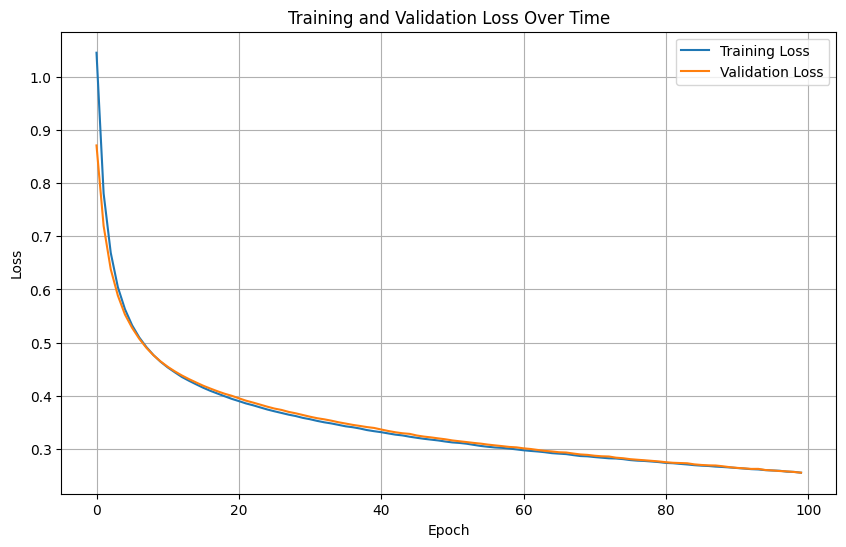

In [ ]:
# Load and prepare data
X, y = prepare_data()

# Split data into training and temporary sets (70% train, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets (50% validation, 50% test of the 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Jumlah data Train: {len(y_train)}")
print(f"Jumlah data Test: {len(y_test)}")

# Train the model with validation tracking
layers, biases, train_losses, val_losses = train_model_with_validation(
    X_train, y_train,
    X_val, y_val,
    input_size=X.shape[1],
    hidden_sizes=HIDDEN_SIZES,
    num_classes=len(np.unique(y)),
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

# Evaluate the model on the test set
accuracy, predictions = evaluate(X_test, y_test, layers, biases)
print(f'\nFinal Test Accuracy: {accuracy:.2f}%')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Jumlah prediksi benar: 1225
Jumlah prediksi salah: 124


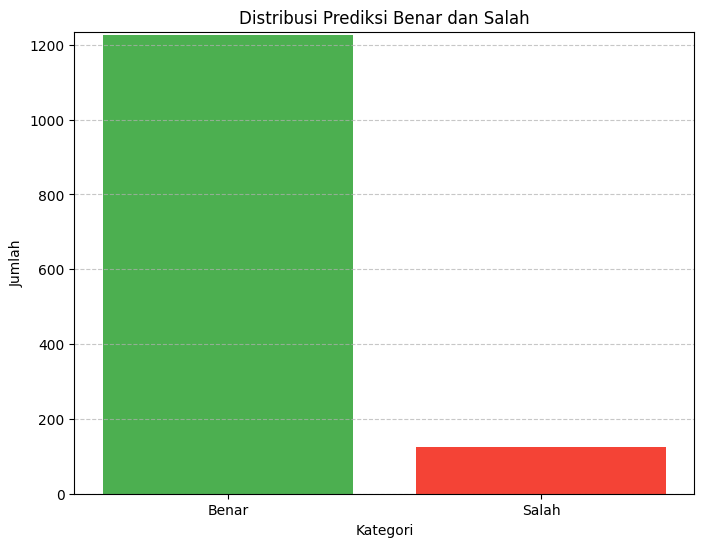

In [ ]:
# Hitung jumlah prediksi benar dan salah
correct_predictions = np.sum(predictions == y_test)
incorrect_predictions = len(y_test) - correct_predictions

print(f"Jumlah prediksi benar: {correct_predictions}")
print(f"Jumlah prediksi salah: {incorrect_predictions}")
labels = ['Benar', 'Salah']
values = [correct_predictions, incorrect_predictions]
colors = ['#4CAF50', '#F44336']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)
plt.title('Distribusi Prediksi Benar dan Salah')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.ylim(0, max(values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()z

##Evaluasi model menggunakan confussion matrix

<Figure size 800x600 with 0 Axes>

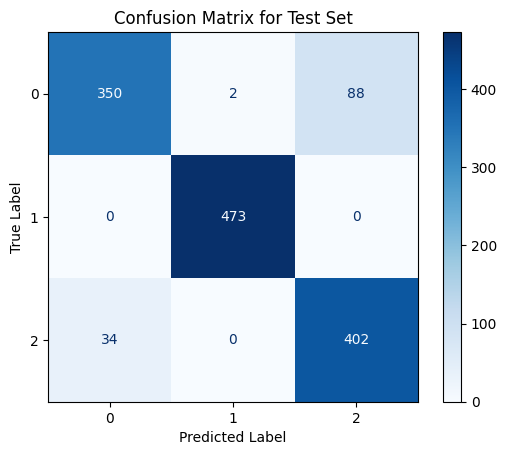

In [ ]:
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show()